In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from math import sqrt
from sklearn.metrics import mean_squared_error
import numpy as np
from pmdarima import auto_arima
import itertools
import warnings
warnings.filterwarnings("ignore")



SEED = 42

In [3]:
dataset = pd.read_csv("/content/gdrive/MyDrive/Time Series/train.csv")

In [4]:
dataset_test = pd.read_csv("/content/gdrive/MyDrive/Time Series/test.csv")

In [5]:
dataset.info()
dataset.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20580 entries, 0 to 20579
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              20580 non-null  int64  
 1   Province_State  8750 non-null   object 
 2   Country_Region  20580 non-null  object 
 3   Date            20580 non-null  object 
 4   ConfirmedCases  20580 non-null  float64
 5   Fatalities      20580 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 964.8+ KB


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
7989,11410,Reunion,France,2020-01-31,0.0,0.0
7499,10710,NaN,Finland,2020-01-31,1.0,0.0
13616,19437,NaN,Russia,2020-02-27,2.0,0.0
14329,20450,NaN,Singapore,2020-03-11,178.0,0.0
17298,24709,Michigan,US,2020-01-30,0.0,0.0


In [6]:
dataset.columns

Index(['Id', 'Province_State', 'Country_Region', 'Date', 'ConfirmedCases',
       'Fatalities'],
      dtype='object')

In [7]:
dataset.shape

(20580, 6)

In [8]:
cnf, dth, rec, act = '#393e46', '#ff2e63', '#21bf73', '#fe9801' 

In [9]:
dataset["Province_State"].isna().sum()

11830

In [10]:
dataset["Province_State"].nunique()

125

In [11]:
dataset["Province_State"].unique()

array([nan, 'Australian Capital Territory', 'New South Wales',
       'Northern Territory', 'Queensland', 'South Australia', 'Tasmania',
       'Victoria', 'Western Australia', 'Alberta', 'British Columbia',
       'Manitoba', 'New Brunswick', 'Newfoundland and Labrador',
       'Nova Scotia', 'Ontario', 'Prince Edward Island', 'Quebec',
       'Saskatchewan', 'Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu',
       'Guangdong', 'Guangxi', 'Guizhou', 'Hainan', 'Hebei',
       'Heilongjiang', 'Henan', 'Hong Kong', 'Hubei', 'Hunan',
       'Inner Mongolia', 'Jiangsu', 'Jiangxi', 'Jilin', 'Liaoning',
       'Macau', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong', 'Shanghai',
       'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Xinjiang', 'Yunnan',
       'Zhejiang', 'Faroe Islands', 'Greenland', 'French Guiana',
       'French Polynesia', 'Guadeloupe', 'Martinique', 'Mayotte',
       'New Caledonia', 'Reunion', 'Saint Barthelemy', 'St Martin',
       'Aruba', 'Curacao', 'Sint Maarten', 'Alabam

In [12]:
cnf

'#393e46'

In [13]:
temp = dataset[["Date", "Fatalities", "ConfirmedCases"]]

In [14]:
temp

,Date,Fatalities,ConfirmedCases
0,2020-01-22,0.0,0.0
1,2020-01-23,0.0,0.0
2,2020-01-24,0.0,0.0
3,2020-01-25,0.0,0.0
4,2020-01-26,0.0,0.0
...,...,...,...
20575,2020-03-27,1.0,5.0
20576,2020-03-28,1.0,7.0
20577,2020-03-29,1.0,7.0
20578,2020-03-30,1.0,7.0


In [15]:
temp = temp.melt(id_vars = "Date", value_vars = ["Fatalities", "ConfirmedCases"])

In [16]:
fig = px.treemap(temp, path = ["variable"], values = "value", height = 225, color_discrete_sequence = [rec, dth])

In [17]:
fig.data[0].textinfo = "label + text + value"
fig.show()

In [18]:
#confirmed cases by countries
cc = dataset.fillna("NA").groupby(["Country_Region", "Province_State", "Date"])["ConfirmedCases"].sum().groupby(["Country_Region", "Province_State"]).max().sort_values().groupby(["Country_Region"]).sum().sort_values(ascending = False)

In [19]:
cc

Country_Region
US                                  188018.0
Italy                               105792.0
Spain                                95923.0
China                                82280.0
Germany                              71808.0
                                      ...   
Central African Republic                 3.0
Liberia                                  3.0
Saint Vincent and the Grenadines         1.0
Papua New Guinea                         1.0
Timor-Leste                              1.0
Name: ConfirmedCases, Length: 173, dtype: float64

In [20]:
top10cc = pd.DataFrame(cc).head(10)

In [21]:
top10cc

,ConfirmedCases
Country_Region,
US,188018.0
Italy,105792.0
Spain,95923.0
China,82280.0
Germany,71808.0
France,52827.0
Iran,44605.0
United Kingdom,25471.0
Switzerland,16605.0


In [22]:
#fatalities cases by country
fc = dataset.fillna("NA").groupby(["Country_Region", "Province_State", "Date"])["Fatalities"].sum().groupby(["Country_Region", "Province_State"]).max().sort_values().groupby(["Country_Region"]).sum().sort_values(ascending = False)

In [23]:
fc

Country_Region
Italy                       12428.0
Spain                        8464.0
US                           3871.0
France                       3532.0
China                        3309.0
                             ...   
Malta                           0.0
Congo (Brazzaville)             0.0
Mongolia                        0.0
Chad                            0.0
Central African Republic        0.0
Name: Fatalities, Length: 173, dtype: float64

In [24]:
top10fc = pd.DataFrame(fc).head(10)
top10fc

,Fatalities
Country_Region,
Italy,12428.0
Spain,8464.0
US,3871.0
France,3532.0
China,3309.0
Iran,2898.0
United Kingdom,1793.0
Netherlands,1040.0
Germany,775.0


In [25]:
fig = px.bar(top10cc, x = top10cc.index, y = "ConfirmedCases", labels = {"x" : "Country"}, color = "ConfirmedCases", color_continuous_scale = px.colors.sequential.Plotly3)

In [26]:
fig.update_layout(title_text = "Confirmed COVID-19 cases by country")
fig.show()

In [27]:
def plot_map(df, col, pal):
  df = df[df[col] > 0]
  fig = px.choropleth(df, locations = "Country_Region", locationmode = "country names", color = col, hover_name = "Country_Region", title = col, hover_data = [col], color_continuous_scale = pal)
  fig.show()

plot_map(cc.reset_index(), "ConfirmedCases", "matter")

In [28]:
#Deaths COVID-19 Cases by Country
fig = px.bar(top10fc, x = top10fc.index, y = "Fatalities", labels = {"x" : "Country"}, color = "Fatalities", color_continuous_scale = px.colors.sequential.Turbo)
fig.update_layout(title_text = "Deaths COVID-19 Cases by Country")
fig.show()

In [29]:
plot_map(fc.reset_index(), "Fatalities", "PuRd")

In [30]:
#Confirmed COVID-19 cases per day in US

df_by_date = pd.DataFrame(dataset.fillna("NA").groupby(["Country_Region", "Date"])["ConfirmedCases"].sum().sort_values().reset_index())

In [31]:
fig = px.bar(df_by_date.loc[(df_by_date["Country_Region"] == "US") & (df_by_date.Date >= "2020-03-01")].sort_values("ConfirmedCases", ascending = False), x = "Date", y = "ConfirmedCases",
             color = "ConfirmedCases", color_continuous_scale = px.colors.sequential.Rainbow)
fig.update_layout(title_text = "Confirmed COVID-19 cases per day in US")
fig.show()

In a very short period of time the virus spread to the United States and held at the **First** place.

In [32]:
#Confirmed COVID-19 cases per day in Italy

df_by_date = pd.DataFrame(dataset.fillna("NA").groupby(["Country_Region", "Date"])["ConfirmedCases"].sum().sort_values().reset_index())
fig = px.bar(df_by_date.loc[(df_by_date["Country_Region"] == "Italy") & (df_by_date.Date >= "2020-03-01")].sort_values("ConfirmedCases", ascending = False),
             x = "Date", y = "ConfirmedCases", color = "ConfirmedCases", color_continuous_scale = px.colors.sequential.Plasma)
fig.update_layout(title_text = 'Confirmed COVID-19 cases per day in Italy')
fig.show()

In **Italy**, the spread of virus was for a long time and therefore affected more people. But in United States in a short time, the spread is more in this way the United States had a great impact.

In [33]:
#Confirmed COVID-19 cases per day in Spain

df_by_date = pd.DataFrame(dataset.fillna("NA").groupby(["Country_Region", "Date"])["ConfirmedCases"].sum().sort_values().reset_index())
fig = px.bar(df_by_date.loc[(df_by_date["Country_Region"] == "Spain") & (df_by_date.Date >= "2020-03-01")].sort_values("ConfirmedCases", ascending = False),
             x = "Date", y = "ConfirmedCases", color = "ConfirmedCases", color_continuous_scale = px.colors.sequential.Plasma)
fig.update_layout(title_text = 'Confirmed COVID-19 cases per day in Spain')
fig.show()

In [34]:
#Confirmed COVID-19 cases per day in China (China is out of the time series as the number of cases in China are now close to 0)

df_by_date = pd.DataFrame(dataset.fillna("NA").groupby(["Country_Region", "Date"])["ConfirmedCases"].sum().sort_values().reset_index())

#The date is taken from 2020-01-22 as the cases in march are all same around 80k
fig = px.bar(df_by_date.loc[(df_by_date["Country_Region"] == "China") & (df_by_date.Date >= "2020-01-22")].sort_values("ConfirmedCases", ascending = False),    
             x = "Date", y = "ConfirmedCases", color = "ConfirmedCases", color_continuous_scale = px.colors.sequential.Plasma)
fig.update_layout(title_text = 'Confirmed COVID-19 cases per day in China')
fig.show()

From the graph, we can see that the cases began at **China**. This virus started and has continued to spread. From this region, the virus began to spread to all parts of the world. In China, confirmed cases are increasing day by day.

In [35]:
def plot_tree(col, dtfr):
  df = dtfr.reset_index()
  fig = px.treemap(df, path = ["Country_Region"], values = col, height =  700,
                   title = col, color_discrete_sequence = px.colors.qualitative.Dark2)
  fig.data[0].textinfo = "label + text + value"
  fig.show()

plot_tree("ConfirmedCases", cc)

In [36]:
plot_tree("Fatalities", fc)

In [37]:
#Top 20

def plot_hbar(df, col, n, hover_data = []):
  fig = px.bar(df.sort_values(col).tail(n), x = col, y = "Country_Region", color = col, text = col, orientation = "h", width = 700, hover_data = hover_data,
               color_discrete_sequence = px.colors.qualitative.Dark2)
  fig.update_layout(title = col, xaxis_title = "", yaxis_title = "", yaxis_categoryorder = "total ascending",
                    uniformtext_minsize = 8, uniformtext_mode = "hide")
  fig.show()

plot_hbar(cc.reset_index(), "ConfirmedCases", 20)

In [38]:
plot_hbar(fc.reset_index(), 'Fatalities', 20)

In [39]:
#Cases over time

temp = dataset.groupby("Date")["ConfirmedCases", "Fatalities"].sum().reset_index()
temp = temp.melt(id_vars = "Date", value_vars = ["ConfirmedCases", "Fatalities"], var_name = "Case", value_name = "Count")

In [40]:
temp.head()

,Date,Case,Count
0,2020-01-22,ConfirmedCases,554.0
1,2020-01-23,ConfirmedCases,653.0
2,2020-01-24,ConfirmedCases,939.0
3,2020-01-25,ConfirmedCases,1432.0
4,2020-01-26,ConfirmedCases,2113.0


In [41]:
fig = px.area(temp, x = "Date", y = "Count", color = "Case", height = 600, width = 700, title = "Cases Over Time", color_discrete_sequence = [rec, dth])
fig.update_layout(xaxis_rangeslider_visible = True)
fig.show()

In [42]:
df = dataset.groupby(["Date", "Country_Region"]).agg("sum").reset_index()
df.head()

,Date,Country_Region,Id,ConfirmedCases,Fatalities
0,2020-01-22,Afghanistan,1,0.0,0.0
1,2020-01-22,Albania,101,0.0,0.0
2,2020-01-22,Algeria,201,0.0,0.0
3,2020-01-22,Andorra,301,0.0,0.0
4,2020-01-22,Angola,401,0.0,0.0


In [43]:
df.columns

Index(['Date', 'Country_Region', 'Id', 'ConfirmedCases', 'Fatalities'], dtype='object')

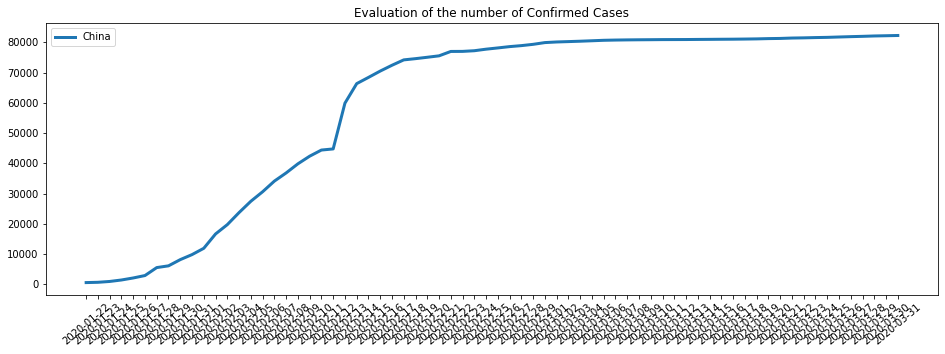

In [44]:
def pltCountry_cases(ConfirmedCases, *argv):
  f, ax = plt.subplots(figsize = (16,5))
  labels = argv
  for i in argv:
    country = df.loc[(df["Country_Region"] == i)]
    plt.plot(country["Date"], country["ConfirmedCases"], linewidth = 3)
    plt.xticks(rotation = 40)
    plt.legend(labels)
    ax.set(title = "Evaluation of the number of Confirmed Cases")

pltCountry_cases('ConfirmedCases','China')

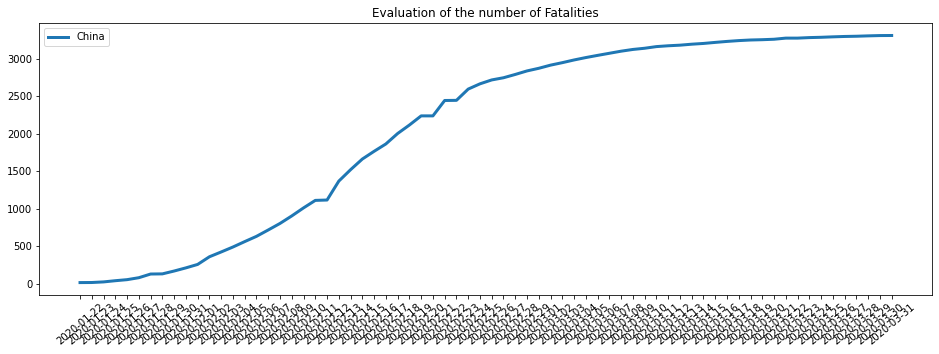

In [45]:
def pltCountry_fatalities(Fatalities, *argv):
  f, ax = plt.subplots(figsize = (16, 5))
  labels = argv
  #print(labels)     #('China',)
  for i in argv:
    #print(i)       #China
    country = df.loc[(df["Country_Region"] == i)]
    plt.plot(country["Date"], country["Fatalities"], linewidth = 3)
    plt.xticks(rotation = 40)
    plt.legend(labels)
    ax.set(title = "Evaluation of the number of Fatalities")

pltCountry_fatalities("Fatalities", "China")

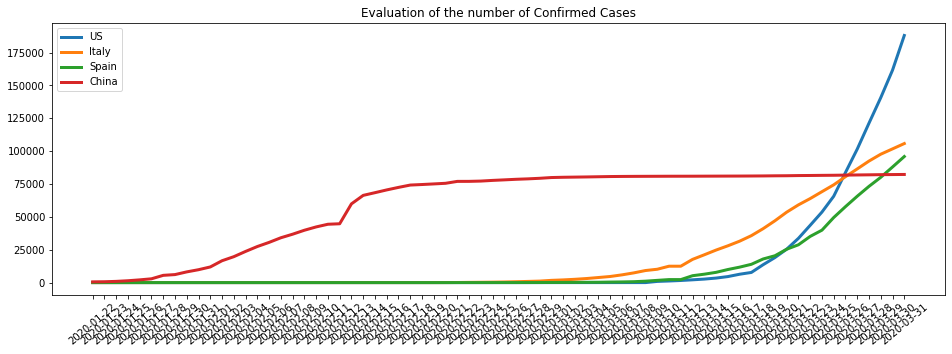

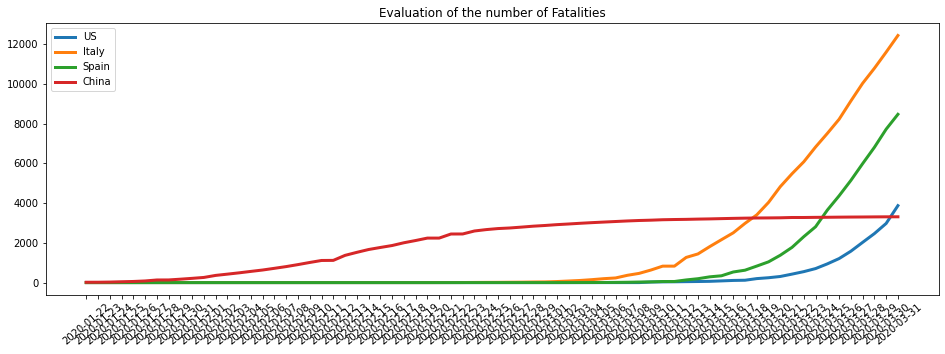

In [46]:
pltCountry_cases("ConfirmedCases", "US", "Italy", "Spain", "China")
pltCountry_fatalities("Fatalities", "US", "Italy", "Spain", "China")

In [47]:
def roll(country, case):
  ts = df.loc[(df["Country_Region"] == country)]
  ts = ts[["Date", case]]
  ts = ts.set_index("Date")
  ts.astype("int64")
  a = len(ts.loc[(ts[case] >= 10)])
  ts = ts[-a : ]
  return (ts.rolling(window = 4, center = False).mean().dropna())

tsc = roll("US", "ConfirmedCases")
tsf= roll("US", "Fatalities")

In [48]:
#create a time series for confirmed cases
sc = pd.Series(tsc.unstack().values, index = tsc.index)

In [49]:
#create a time series for Fatalities
sf = pd.Series(tsf.unstack().values, index = tsf.index)

Text(0, 0.5, 'ConfirmedCases')

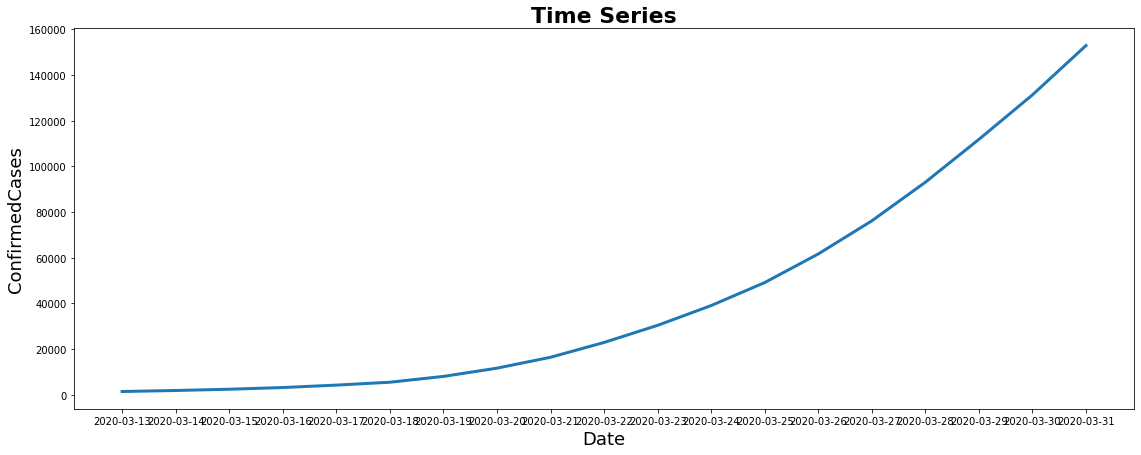

In [50]:
fig = plt.figure(figsize = (19, 7))
plt.plot(sc, linewidth = 3)
plt.title("Time Series", fontsize = 22, fontweight = "bold")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("ConfirmedCases", fontsize = 18)

Text(0, 0.5, 'Fatalities')

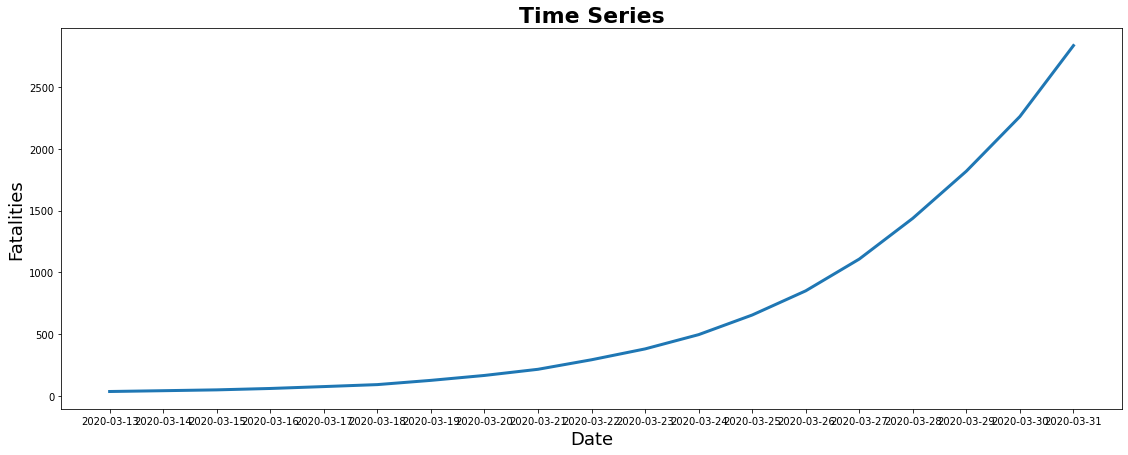

In [51]:
fig = plt.figure(figsize = (19, 7))
plt.plot(sf, linewidth = 3)
plt.title("Time Series", fontsize = 22, fontweight = "bold")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Fatalities", fontsize = 18)

In [52]:
tsc = roll("China", "ConfirmedCases")
tsf= roll("China", "Fatalities")

In [53]:
sc = pd.Series(tsc.unstack().values, index = tsc.index)
sf = pd.Series(tsf.unstack().values, index = tsf.index)

Text(0, 0.5, 'ConfirmedCases')

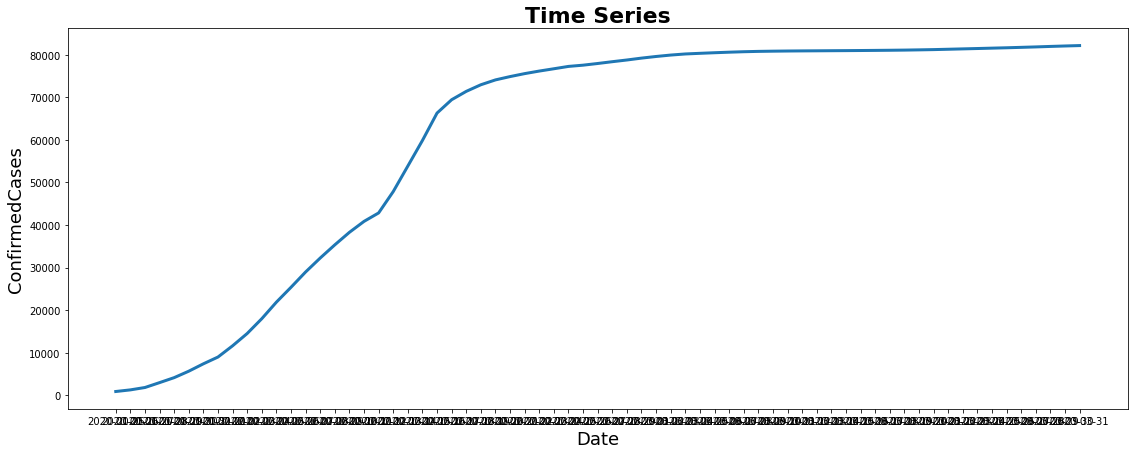

In [54]:
fig = plt.figure(figsize = (19, 7))
plt.plot(sc, linewidth = 3)
plt.title("Time Series", fontsize = 22, fontweight = "bold")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("ConfirmedCases", fontsize = 18)

Text(0, 0.5, 'Fatalities')

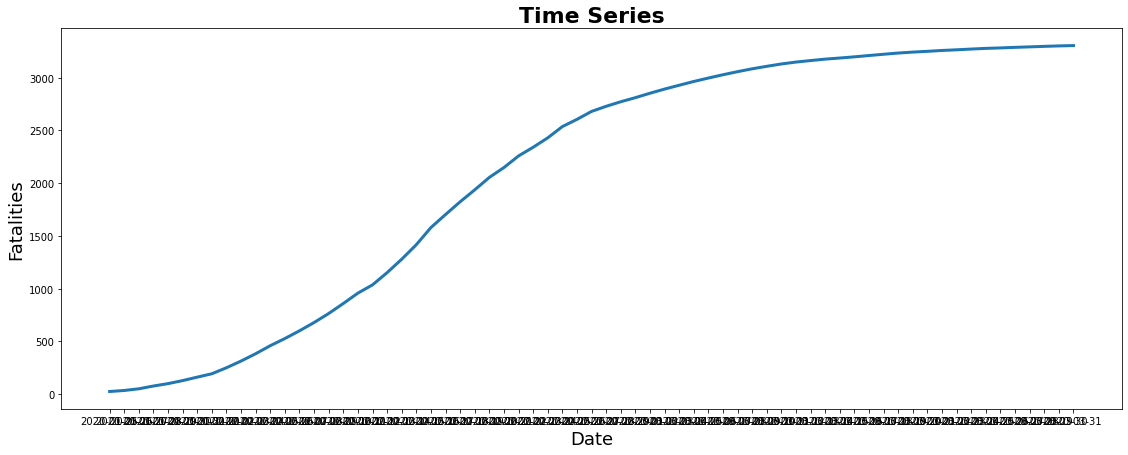

In [55]:
fig = plt.figure(figsize = (19, 7))
plt.plot(sf, linewidth = 3)
plt.title("Time Series", fontsize = 22, fontweight = "bold")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Fatalities", fontsize = 18)

In [56]:
def roll(country, case):
  ts = df.loc[(df["Country_Region"] == country)]
  ts = ts[["Date", case]]
  ts = ts.set_index("Date")
  ts.astype("int64")
  a = len(ts.loc[(ts[case] >= 10)])
  ts = ts[-a : ]
  return (ts.rolling(window = 4, center = False).mean().dropna())

tsc = roll("US", "ConfirmedCases")
tsf= roll("US", "Fatalities")

In [57]:
sc = pd.Series(tsc.unstack().values, index = tsc.index)
sf = pd.Series(tsf.unstack().values, index = tsf.index)

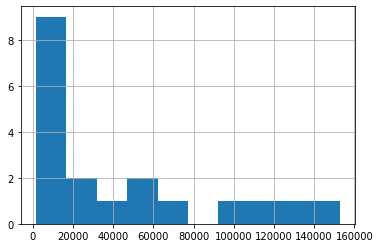

In [58]:
sc.hist()

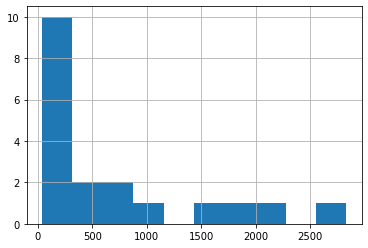

In [59]:
sf.hist()

**TIMESERIES** assumes a relationship between an observation and the previous observation. Previous observations in a time series are called lags, with the observation at the previous time step called lag = 1, the two time step observation there is lag = 2, and so on. One type of graph useful for exploring the relationship between each observation and an offset of that observation is called the scatter plot. Pandas has a built-in function for exactly that called the lag plot. It plots the observation at time t on the x-axis and offset = 1 observation (t-1) on the y-axis.

If the points cluster along a diagonal running from the bottom left to the top right of the graph, this suggests a positive correlation relationship. If the points cluster along a diagonal line running from top left to bottom right, this suggests a negative correlation relationship. Both relationships are good because they can be modeled. More tighter points in the diagonal line suggest a stronger relationship, and more scatter from the line suggests a weaker relationship. A bullet in the middle or a spread through the plot suggests a weak or no relationship.

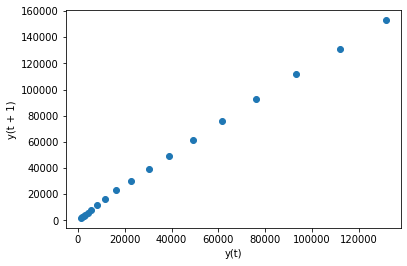

In [60]:
lag_plot(sc)

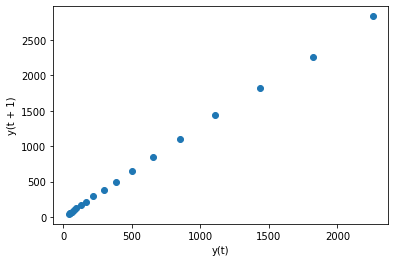

In [61]:
lag_plot(sf)

We can quantify the strength and type of relationship between observations and their delays. In statistics, this is called correlation, and when calculated against lag values ​​in time series, it is called autocorrelation. A correlation value calculated between two groups of numbers, such as cases and their offset values ​​= 1, results in a number between -1 and 1. The sign of this number indicates a negative or positive correlation, respectively. A value close to zero suggests a weak correlation, while a value closer to -1 or 1 indicates a strong correlation.


Correlation values, called correlation coefficients, can be calculated for each observation and for different lag values. Once calculated, a graph can be created to help better understand how this relationship changes with the offset. This type of plot is called an autocorrelation plot.

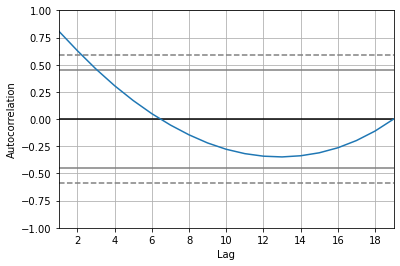

In [62]:
autocorrelation_plot(sc)

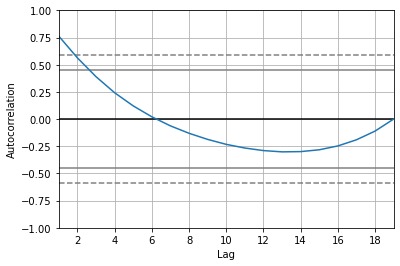

In [63]:
autocorrelation_plot(sf)

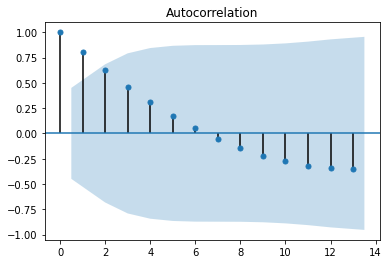

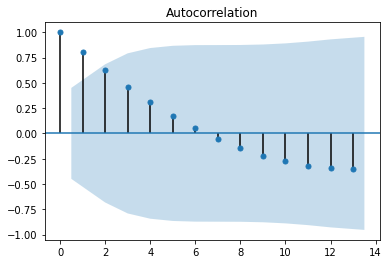

In [64]:
#autocorrelation plot of time series as a line plot for confirmed cases
plot_acf(sc)

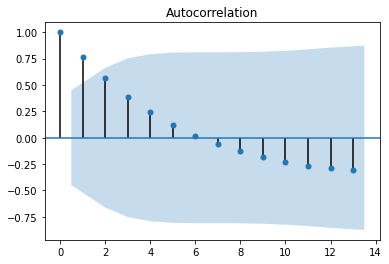

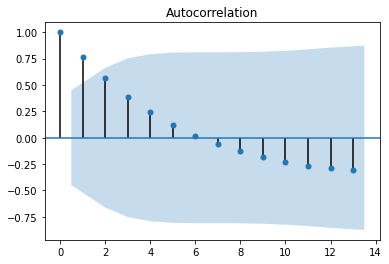

In [65]:
#autocorrelation plot of time series as a line plot for fatalities
plot_acf(sf)


To make sure the data is stationary or not, we run a fixed statistical test using the following code

In [66]:
def ad_test(dataset):
  dftest = adfuller(dataset, autolag = "AIC")
  print("1. ADF : ", dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num of Lags : ", dftest[2])
  print("4. Num of observations Used for ADF Regression : ", dftest[3])
  print("5. Critical Values : ")
  for key, val in dftest[4].items():
    print("\t", key, ":", val)

ad_test(sc)

1. ADF :  -1.3512277227800928
2. P-Value :  0.6054221987938646
3. Num of Lags :  7
4. Num of observations Used for ADF Regression :  11
5. Critical Values : 
	 1% : -4.223238279489106
	 5% : -3.189368925619835
	 10% : -2.729839421487603


In [67]:
ad_test(sf)

1. ADF :  -1.4687412639901525
2. P-Value :  0.5489140523266745
3. Num of Lags :  6
4. Num of observations Used for ADF Regression :  12
5. Critical Values : 
	 1% : -4.137829282407408
	 5% : -3.1549724074074077
	 10% : -2.7144769444444443


P- value is greater than **0.05**, therefore the data is not stationary

In [68]:
sc_diff = sc.diff(periods = 1)
sf_diff = sf.diff(periods = 1)

sc_diff = sc_diff[1 : ]
sf_diff = sf_diff[1 : ]

In [69]:
#Format Date

dataset["Date"] = dataset["Date"].apply(lambda x : x.replace("-",""))
dataset["Date"] = dataset["Date"].astype(int)
dataset.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,20200122,0.0,0.0
1,2,NaN,Afghanistan,20200123,0.0,0.0
2,3,NaN,Afghanistan,20200124,0.0,0.0
3,4,NaN,Afghanistan,20200125,0.0,0.0
4,5,NaN,Afghanistan,20200126,0.0,0.0


In [70]:
#drop NaNs

dataset = dataset.drop(["Province_State"], axis = 1)
datase = dataset.dropna()
dataset.isnull().sum()

Id                0
Country_Region    0
Date              0
ConfirmedCases    0
Fatalities        0
dtype: int64

In [71]:
dataset_test.head()

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-03-19
1,2,NaN,Afghanistan,2020-03-20
2,3,NaN,Afghanistan,2020-03-21
3,4,NaN,Afghanistan,2020-03-22
4,5,NaN,Afghanistan,2020-03-23


In [72]:
#cleaning test data

dataset_test["Date"] = dataset_test["Date"].apply(lambda x : x.replace("-",""))
dataset_test["Date"] = dataset_test["Date"].astype(int)

In [73]:
dataset.sample(5)

,Id,Country_Region,Date,ConfirmedCases,Fatalities
18036,25747,US,20200308,0.0,0.0
16193,23124,US,20200214,0.0,0.0
1757,2508,Benin,20200129,0.0,0.0
10499,14970,Laos,20200331,9.0,0.0
18650,26631,US,20200221,0.0,0.0


In [74]:
dataset_test.sample(5)

,ForecastId,Province_State,Country_Region,Date
8230,8231,NaN,Portugal,20200405
10643,10644,Michigan,US,20200410
11743,11744,Virginia,US,20200323
6913,6914,NaN,Mali,20200421
652,653,Western Australia,Australia,20200326


In [75]:
dataset_test.isna().sum()

ForecastId           0
Province_State    7267
Country_Region       0
Date                 0
dtype: int64

In [76]:
dataset2 = dataset.loc[(dataset["Country_Region"] == "US")]
dataset_test2 = dataset_test.loc[(dataset_test["Country_Region"] == "US")]

In [77]:
dataset2.head()

,Id,Country_Region,Date,ConfirmedCases,Fatalities
15680,22401,US,20200122,0.0,0.0
15681,22402,US,20200123,0.0,0.0
15682,22403,US,20200124,0.0,0.0
15683,22404,US,20200125,0.0,0.0
15684,22405,US,20200126,0.0,0.0


In [78]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3780 entries, 15680 to 19459
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              3780 non-null   int64  
 1   Country_Region  3780 non-null   object 
 2   Date            3780 non-null   int64  
 3   ConfirmedCases  3780 non-null   float64
 4   Fatalities      3780 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 177.2+ KB


In [79]:
dataset_test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2322 entries, 9632 to 11953
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ForecastId      2322 non-null   int64 
 1   Province_State  2322 non-null   object
 2   Country_Region  2322 non-null   object
 3   Date            2322 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 90.7+ KB


In [80]:
dataset2.isna().sum()

Id                0
Country_Region    0
Date              0
ConfirmedCases    0
Fatalities        0
dtype: int64

In [81]:
dataset_test2.isna().sum()

ForecastId        0
Province_State    0
Country_Region    0
Date              0
dtype: int64

In [82]:
x = dataset2[["Date"]]
y1 = dataset2[["ConfirmedCases"]]
y2 = dataset2[["Fatalities"]]
x_test = dataset_test2[["Date"]]

In [83]:
X = StandardScaler().fit_transform(x)
X_test = StandardScaler().fit_transform(x_test)
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size = 0.25, random_state = SEED)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size = 0.25, random_state = SEED)

In [84]:
def split(ts):
  size = int(len(ts) * 0.85)
  train = ts[ : size]
  test = ts[size : ]
  return (train, test)

tscc = tsc["ConfirmedCases"].values
tsfc = tsf["Fatalities"].values
traincc, testcc = split(tscc)
trainfc, testfc = split(tsfc)

In [85]:
#list to store RMSE

rmsecc = []
rmsefc = []

In [86]:
#train autoregression for confirmed cases

predictions = []
model = AR(traincc)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

In [87]:
#walk forward over time steps in test

history = traincc[len(traincc)-window:]
history = [history[i] for i in range(len(history))]
predictions = []

for t in range(len(testcc)):
  length = len(history)
  lag = [history[i] for i in range(length-window, length)]
  yhat = coef[0]

  for d in range(window):
    yhat += coef[d+1] * lag[window-d-1]
  obs = testcc[t]
  predictions.append(yhat)
  history.append(obs)

  print("Predicted = %f, expected = %f" % (yhat, obs))

RMSE_arcc = sqrt(mean_squared_error(y_true = testcc, y_pred = predictions))

Predicted = 107609.491768, expected = 111849.750000
Predicted = 118120.899463, expected = 131323.750000
Predicted = 126394.475260, expected = 152933.250000


In [88]:
RMSE_arcc

17287.776190837027

In [89]:
print('Test RMSE: %.3f' % RMSE_arcc)
rmsecc.append(RMSE_arcc)

Test RMSE: 17287.776


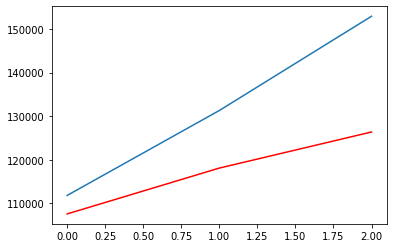

In [90]:
# plot

plt.plot(testcc)
plt.plot(predictions, color = 'red')     #this is not clear to me (doubts in it)

In [91]:
#train autoregression for Fatalities

predictions = []
model = AR(trainfc)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

In [92]:
# walk forward over time steps in test

history = trainfc[len(trainfc)-window:]
history = [history[i] for i in range(len(history))]
predictions = []

for t in range(len(testfc)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = testfc[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

RMSE_arfc = np.sqrt(mean_squared_error(testfc, predictions))

predicted=1913.785998, expected=1818.250000
predicted=2595.126260, expected=2260.000000
predicted=3546.292690, expected=2833.000000


In [93]:
print('Test RMSE: %.3f' % RMSE_arfc)
rmsefc.append(RMSE_arfc)

Test RMSE: 458.339


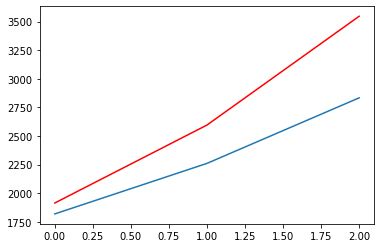

In [94]:
# plot

plt.plot(testfc)
plt.plot(predictions, color = 'red')

In [95]:
test_period = 3

for i in range(test_period):
  print("Predicted = %f, expected = %f" % (predictions[i], testcc[i]))

  RMSE_arfc = np.sqrt(mean_squared_error(testfc[ : test_period], predictions[ : test_period]))

Predicted = 1913.785998, expected = 111849.750000
Predicted = 2595.126260, expected = 131323.750000
Predicted = 3546.292690, expected = 152933.250000


In [96]:
#checking for the best model

stepwise_fit = auto_arima(traincc, trace = True, suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=244.545, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=219.670, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=221.330, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=221.160, Time=0.15 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=232.390, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=219.031, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=225.605, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=218.665, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=229.317, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=218.800, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=220.783, Time=0.17 se

In [97]:
#checking for the best model

stepwise_fit = auto_arima(trainfc, trace = True, suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=138.832, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=118.883, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=120.329, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=119.725, Time=0.04 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 0.586 seconds


In [98]:
def mape(y2, y_pred):
  return sqrt(mean_squared_error(y_true = y2, y_pred = y_pred))

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   14
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -107.739
Method:                       css-mle   S.D. of innovations            513.152
Date:                Fri, 04 Jun 2021   AIC                            221.479
Time:                        03:29:10   BIC                            223.396
Sample:                             2   HQIC                           221.301
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1208.8970    543.051      2.226      0.026     144.537    2273.257
ar.L1.D2.y     0.7979      0.177      4.512      0.000       0.451       1.144
                                    Roots           

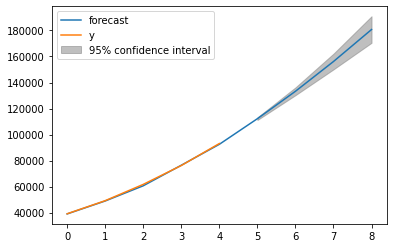

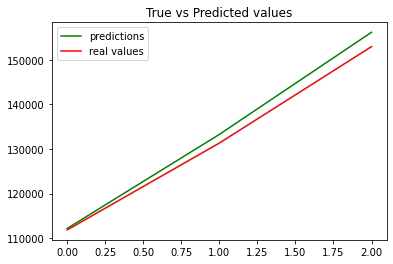

In [99]:
#Arima modeling for ts
def arima(ts,test):
    p = d = q = range(0,6)
    a = 99999
    pdq = list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic <= a) :
                a = result.aic
                param = var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order = param)
    result = model.fit()
    result.plot_predict(start = int(len(ts) * 0.7), end = int(len(ts) * 1.2))
    pred = result.forecast(steps = len(test))[0]
    
    #Plotting results
    f,ax = plt.subplots()
    plt.plot(pred, c = 'green', label = 'predictions')
    plt.plot(test, c = 'red',label = 'real values')
    plt.legend()
    plt.title('True vs Predicted values')
    
    #Printing the error metrics
    print(result.summary())        
    
    print('\nMean squared error: %f'%mape(test,pred))
    return pred

pred = arima(traincc, testcc)
RMSE_arimacc = sqrt(mean_squared_error(y_true = testcc, y_pred = pred))
rmsecc.append(RMSE_arimacc)

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   14
Model:                 ARIMA(0, 2, 3)   Log Likelihood                 -54.564
Method:                       css-mle   S.D. of innovations              9.760
Date:                Fri, 04 Jun 2021   AIC                            119.127
Time:                        03:29:15   BIC                            122.323
Sample:                             2   HQIC                           118.832
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.4077      8.940      2.954      0.003       8.886      43.929
ma.L1.D2.y     0.8842      0.263      3.367      0.001       0.370       1.399
ma.L2.D2.y     0.8842      0.326      2.716      0.0

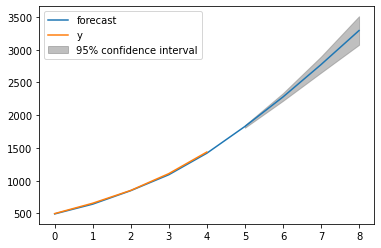

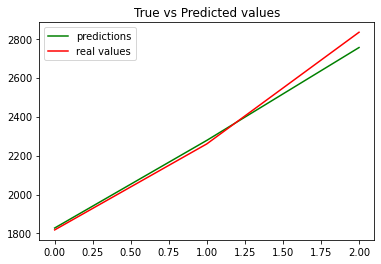

In [100]:
pred = arima(trainfc, testfc)
RMSE_arimafc = sqrt(mean_squared_error(y_true = testfc, y_pred = pred))
rmsefc.append(RMSE_arimafc)